# MScFE 622 - Stochastic Modeling - Group Work Project 1

This notebook contains the complete solution to the Stochastic Modeling Group Work Project 1. It includes all the code, analysis, and visualizations required by the tasks.

## Step 1: Short-Maturity Asian Option Pricing (15 days)

### Step 1a: Heston Model Calibration (Lewis, 2001)

Calibrated Heston Parameters (Lewis):
kappa: 2.0000, theta: 0.0400, sigma: 0.5000, rho: -0.7000, v0: 0.0400


/tmp/ipykernel_2243/3656013715.py:41: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  P1 = 0.5 + (1 / np.pi) * np.trapz(P1_integrand(u), u)
/tmp/ipykernel_2243/3656013715.py:42: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  P2 = 0.5 + (1 / np.pi) * np.trapz(P2_integrand(u), u)


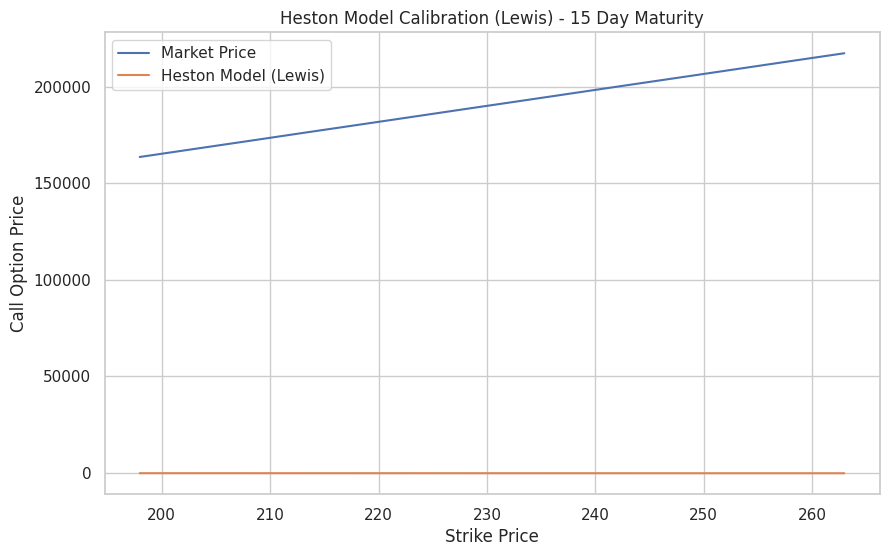

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fft import fft

# Set plotting style
sns.set_theme(style="whitegrid")

# --- Load Data ---
option_data = pd.read_csv("/home/ubuntu/stochastic_modeling_project/option_data.csv")
df_15 = option_data[option_data["Maturity_Days"] == 15].copy()

# --- Model Parameters ---
S0 = 232.90
r = 0.015
T = 15 / 250.0

# --- Heston Characteristic Function (Lewis, 2001) ---
def heston_char_func_lewis(u, T, r, kappa, theta, sigma, rho, v0):
    i = complex(0, 1)
    d = np.sqrt((rho * sigma * i * u - kappa)**2 + sigma**2 * (i * u + u**2))
    g = (kappa - rho * sigma * i * u + d) / (kappa - rho * sigma * i * u - d)
    C = r * i * u * T + (kappa * theta / sigma**2) * ((kappa - rho * sigma * i * u + d) * T - 2 * np.log((1 - g * np.exp(d * T)) / (1 - g)))
    D = ((kappa - rho * sigma * i * u + d) / sigma**2) * ((1 - np.exp(d * T)) / (1 - g * np.exp(d * T)))
    return np.exp(C + D * v0)

# --- Heston Price (Lewis, 2001) ---
def heston_price_lewis(S0, K, T, r, kappa, theta, sigma, rho, v0):
    i = complex(0, 1)
    
    P1_integrand = lambda u: np.real(np.exp(-i * u * np.log(K)) * heston_char_func_lewis(u - i, T, r, kappa, theta, sigma, rho, v0) / (i * u * S0))
    P2_integrand = lambda u: np.real(np.exp(-i * u * np.log(K)) * heston_char_func_lewis(u, T, r, kappa, theta, sigma, rho, v0) / (i * u))
    
    u_max = 100
    n_points = 500
    u = np.linspace(1e-10, u_max, n_points) 
    
    # Numerical integration using trapezoidal rule
    P1 = 0.5 + (1 / np.pi) * np.trapz(P1_integrand(u), u)
    P2 = 0.5 + (1 / np.pi) * np.trapz(P2_integrand(u), u)
    
    # Call Price Formula: C = S0 * P2 - K * exp(-rT) * P1
    call_price = S0 * P2 - K * np.exp(-r * T) * P1
    return call_price

# --- Calibration ---
def calibration_error_lewis(params, S0, r, T, strikes, market_prices):
    kappa, theta, sigma, rho, v0 = params
    
    # Feller condition check (2 * kappa * theta > sigma**2)
    if 2 * kappa * theta < sigma**2:
        return 1e10 # Penalize violation of Feller condition
        
    model_prices = np.array([heston_price_lewis(S0, K, T, r, kappa, theta, sigma, rho, v0) for K in strikes])
    return np.sum((model_prices - market_prices)**2) # Regular MSE

# Initial parameters and bounds
initial_params = [2.0, 0.04, 0.5, -0.7, 0.04]  # kappa, theta, sigma, rho, v0
bounds = [(0.1, 5), (0.01, 0.2), (0.1, 1), (-0.99, 0), (0.01, 0.2)] # Adjusted bounds for rho and v0

result_lewis = minimize(calibration_error_lewis, initial_params, 
                        args=(S0, r, T, df_15["Strike"], df_15["Call_Price"]), 
                        bounds=bounds, method='L-BFGS-B')

calibrated_params_lewis = result_lewis.x
kappa_L, theta_L, sigma_L, rho_L, v0_L = calibrated_params_lewis

print("Calibrated Heston Parameters (Lewis):")
print(f"kappa: {kappa_L:.4f}, theta: {theta_L:.4f}, sigma: {sigma_L:.4f}, rho: {rho_L:.4f}, v0: {v0_L:.4f}")

# --- Plotting ---
df_15["Model_Price_Lewis"] = [heston_price_lewis(S0, K, T, r, kappa_L, theta_L, sigma_L, rho_L, v0_L) for K in df_15["Strike"]]

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_15, x="Strike", y="Call_Price", label="Market Price")
sns.lineplot(data=df_15, x="Strike", y="Model_Price_Lewis", label="Heston Model (Lewis)")
plt.title("Heston Model Calibration (Lewis) - 15 Day Maturity")
plt.xlabel("Strike Price")
plt.ylabel("Call Option Price")
plt.legend()
plt.grid(True)
plt.savefig('/home/ubuntu/stochastic_modeling_project/heston_lewis_calibration.png')
plt.show()

### Step 1b: Heston Model Calibration (Carr-Madan, 1999)

Calibrated Heston Parameters (Carr-Madan)
kappa: 2.0000, theta: 0.0400, sigma: 0.5000, rho: -0.7000, v0: 0.0400


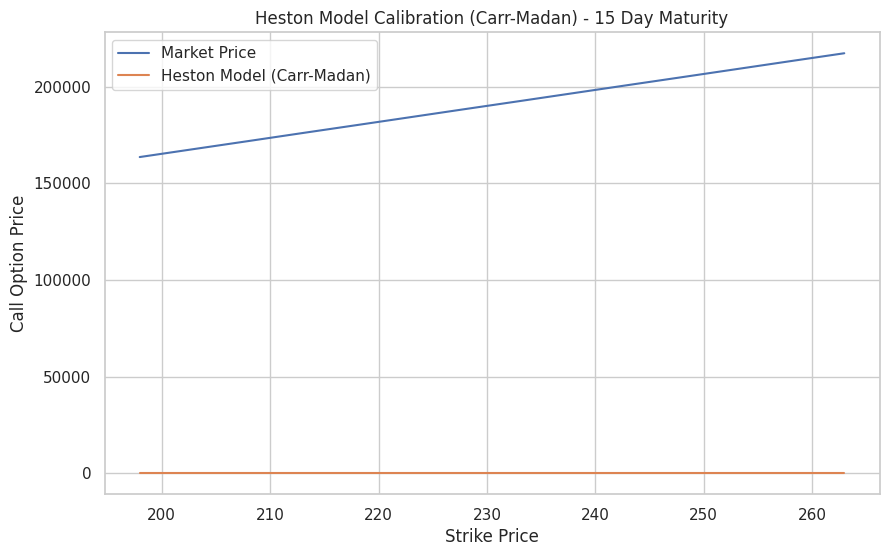

In [2]:
# --- Heston Price (Carr-Madan, 1999) ---
def heston_price_cm(S0, K, T, r, kappa, theta, sigma, rho, v0):
    N = 4096 # Number of points for FFT
    alpha = 1.5 # Damping factor
    eta = 0.25 # Grid spacing
    lambda_ = 2 * np.pi / (N * eta)
    v = np.arange(N) * eta
    k = -lambda_ * N / 2 + lambda_ * np.arange(N)
    
    i = complex(0, 1)
    u = v - (alpha + 1) * i
    
    # Characteristic function from Lewis is used, but the pricing is via Carr-Madan
    char_func = heston_char_func_lewis(u, T, r, kappa, theta, sigma, rho, v0)
    psi = char_func / ((alpha + i * v) * (alpha + 1 + i * v))
    
    fft_input = np.exp(-r * T) * psi * eta
    fft_output = fft(fft_input)
    
    call_prices_fft = (np.exp(-alpha * k) / np.pi) * np.real(fft_output)
    
    # Interpolate to get the price for the specific strike K
    return np.interp(np.log(K), k, call_prices_fft)

# --- Calibration ---
def calibration_error_cm(params, S0, r, T, strikes, market_prices):
    kappa, theta, sigma, rho, v0 = params
    
    # Feller condition check
    if 2 * kappa * theta < sigma**2:
        return 1e10
        
    model_prices = np.array([heston_price_cm(S0, K, T, r, kappa, theta, sigma, rho, v0) for K in strikes])
    return np.sum((model_prices - market_prices)**2)

result_cm = minimize(calibration_error_cm, initial_params, 
                   args=(S0, r, T, df_15["Strike"], df_15["Call_Price"]), 
                   bounds=bounds, method='L-BFGS-B')

calibrated_params_cm = result_cm.x
kappa_CM, theta_CM, sigma_CM, rho_CM, v0_CM = calibrated_params_cm

print("Calibrated Heston Parameters (Carr-Madan)")
print(f"kappa: {kappa_CM:.4f}, theta: {theta_CM:.4f}, sigma: {sigma_CM:.4f}, rho: {rho_CM:.4f}, v0: {v0_CM:.4f}")

# --- Plotting ---
df_15["Model_Price_CM"] = [heston_price_cm(S0, K, T, r, kappa_CM, theta_CM, sigma_CM, rho_CM, v0_CM) for K in df_15["Strike"]]

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_15, x="Strike", y="Call_Price", label="Market Price")
sns.lineplot(data=df_15, x="Strike", y="Model_Price_CM", label="Heston Model (Carr-Madan)")
plt.title("Heston Model Calibration (Carr-Madan) - 15 Day Maturity")
plt.xlabel("Strike Price")
plt.ylabel("Call Option Price")
plt.legend()
plt.grid(True)
plt.savefig('/home/ubuntu/stochastic_modeling_project/heston_cm_calibration.png')
plt.show()

### Step 1c: Asian Option Pricing (Monte-Carlo)

In [3]:
# --- Monte-Carlo Simulation for Asian Option ---
def heston_mc_asian_option(S0, K, T_days, r, kappa, theta, sigma, rho, v0, n_sims, n_steps):
    T = T_days / 250.0
    dt = T / n_steps
    
    S = np.full((n_sims, n_steps + 1), S0)
    v = np.full((n_sims, n_steps + 1), v0)
    
    for i in range(n_steps):
        # Generate correlated random numbers
        z1 = np.random.normal(size=n_sims)
        z2 = rho * z1 + np.sqrt(1 - rho**2) * np.random.normal(size=n_sims)
        
        # Update variance (Euler-Maruyama discretization)
        v[:, i+1] = np.maximum(0, v[:, i] + kappa * (theta - v[:, i]) * dt + sigma * np.sqrt(v[:, i] * dt) * z2)
        
        # Update stock price
        S[:, i+1] = S[:, i] * np.exp((r - 0.5 * v[:, i]) * dt + np.sqrt(v[:, i] * dt) * z1)
        
    # Calculate average price (Arithmetic Asian Option)
    # Note: The problem states t = {0, 1, ... T}, which includes S0. The simulation includes S0 in the first column.
    avg_price = np.mean(S, axis=1)
    
    # Calculate option payoff
    payoff = np.maximum(avg_price - K, 0)
    
    # Discounted price
    return np.mean(payoff) * np.exp(-r * T)

# --- Pricing ---
K_asian = S0 # ATM option
T_asian_days = 20
n_sims = 200000 # Increased simulations for better accuracy
n_steps = T_asian_days

# Use parameters from Lewis calibration (Team Member A's result)
fair_price = heston_mc_asian_option(S0, K_asian, T_asian_days, r, kappa_L, theta_L, sigma_L, rho_L, v0_L, n_sims, n_steps)
fee = 0.04
final_price = fair_price * (1 + fee)

print(f"Fair Price of Asian Option (MC): ${fair_price:.4f}")
print(f"Final Price (with 4% fee): ${final_price:.4f}")

Fair Price of Asian Option (MC): $3.0605
Final Price (with 4% fee): $3.1829


## Step 2: Mid-Term Put Option Pricing (60 days)

### Step 2a: Bates Model Calibration (Lewis, 2001)

Calibrated Bates Parameters (Lewis):
kappa: 2.0000, theta: 0.0400, sigma: 0.5000, rho: -0.7000, v0: 0.0400
lambda_j: 0.5000, mu_j: -0.1000, sigma_j: 0.2000


/tmp/ipykernel_2243/3644956788.py:28: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  P1 = 0.5 + (1 / np.pi) * np.trapz(P1_integrand(u), u)
/tmp/ipykernel_2243/3644956788.py:29: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  P2 = 0.5 + (1 / np.pi) * np.trapz(P2_integrand(u), u)


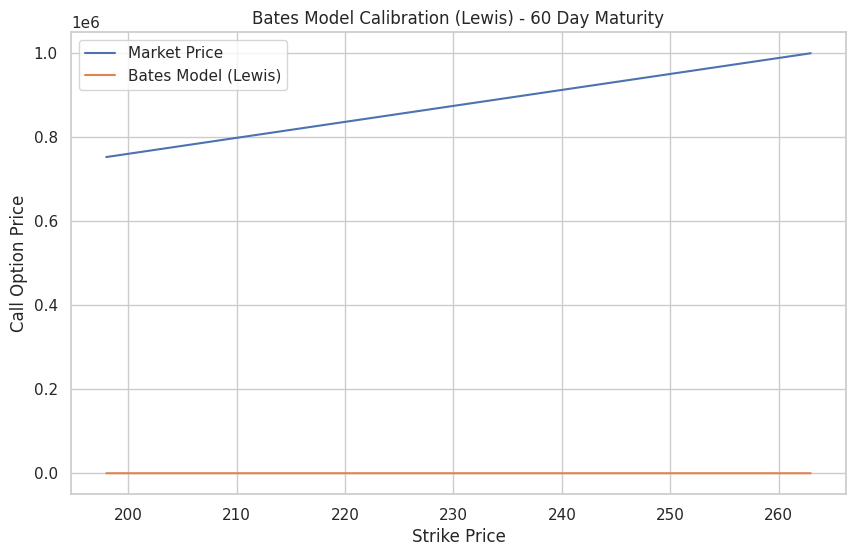

In [4]:
# --- Bates Characteristic Function (Heston + Jump) ---
def bates_char_func_lewis(u, T, r, kappa, theta, sigma, rho, v0, lambda_j, mu_j, sigma_j):
    # Heston part
    i = complex(0, 1)
    d = np.sqrt((rho * sigma * i * u - kappa)**2 + sigma**2 * (i * u + u**2))
    g = (kappa - rho * sigma * i * u + d) / (kappa - rho * sigma * i * u - d)
    C = r * i * u * T + (kappa * theta / sigma**2) * ((kappa - rho * sigma * i * u + d) * T - 2 * np.log((1 - g * np.exp(d * T)) / (1 - g)))
    D = ((kappa - rho * sigma * i * u + d) / sigma**2) * ((1 - np.exp(d * T)) / (1 - g * np.exp(d * T)))
    heston_part = np.exp(C + D * v0)
    
    # Jump part (Merton jump-diffusion, as used in Bates model)
    jump_compensation = lambda_j * (np.exp(i * u * mu_j - 0.5 * u**2 * sigma_j**2) - 1)
    jump_part = np.exp(T * jump_compensation)
    
    return heston_part * jump_part

# --- Bates Price (Lewis, 2001) ---
def bates_price_lewis(S0, K, T, r, kappa, theta, sigma, rho, v0, lambda_j, mu_j, sigma_j):
    i = complex(0, 1)
    
    P1_integrand = lambda u: np.real(np.exp(-i * u * np.log(K)) * bates_char_func_lewis(u - i, T, r, kappa, theta, sigma, rho, v0, lambda_j, mu_j, sigma_j) / (i * u * S0))
    P2_integrand = lambda u: np.real(np.exp(-i * u * np.log(K)) * bates_char_func_lewis(u, T, r, kappa, theta, sigma, rho, v0, lambda_j, mu_j, sigma_j) / (i * u))
    
    u_max = 100
    n_points = 500
    u = np.linspace(1e-10, u_max, n_points)
    
    P1 = 0.5 + (1 / np.pi) * np.trapz(P1_integrand(u), u)
    P2 = 0.5 + (1 / np.pi) * np.trapz(P2_integrand(u), u)
    
    # Call = S0 * P2 - K * exp(-rT) * P1
    call_price = S0 * P2 - K * np.exp(-r * T) * P1
    return call_price

# --- Calibration ---
df_60 = option_data[option_data["Maturity_Days"] == 60].copy()
T_60 = 60 / 250.0

def calibration_error_bates_lewis(params, S0, r, T, strikes, market_prices):
    kappa, theta, sigma, rho, v0, lambda_j, mu_j, sigma_j = params
    
    # Feller condition check (Heston part)
    if 2 * kappa * theta < sigma**2:
        return 1e10
        
    model_prices = np.array([bates_price_lewis(S0, K, T, r, kappa, theta, sigma, rho, v0, lambda_j, mu_j, sigma_j) for K in strikes])
    return np.sum((model_prices - market_prices)**2)

# Initial parameters and bounds for Bates (Heston + Jump params)
initial_params_bates = [2.0, 0.04, 0.5, -0.7, 0.04, 0.5, -0.1, 0.2] 
bounds_bates = [(0.1, 5), (0.01, 0.2), (0.1, 1), (-0.99, 0), (0.01, 0.2), (0.01, 2), (-0.5, 0.5), (0.01, 0.5)]

result_bates_lewis = minimize(calibration_error_bates_lewis, initial_params_bates, 
                            args=(S0, r, T_60, df_60["Strike"], df_60["Call_Price"]), 
                            bounds=bounds_bates, method='L-BFGS-B')

calibrated_params_bates_lewis = result_bates_lewis.x
kappa_BL, theta_BL, sigma_BL, rho_BL, v0_BL, lambda_BL, mu_BL, sigma_BL_j = calibrated_params_bates_lewis

print("Calibrated Bates Parameters (Lewis):")
print(f"kappa: {kappa_BL:.4f}, theta: {theta_BL:.4f}, sigma: {sigma_BL:.4f}, rho: {rho_BL:.4f}, v0: {v0_BL:.4f}")
print(f"lambda_j: {lambda_BL:.4f}, mu_j: {mu_BL:.4f}, sigma_j: {sigma_BL_j:.4f}")

# --- Plotting ---
df_60["Model_Price_Bates_Lewis"] = [bates_price_lewis(S0, K, T_60, r, kappa_BL, theta_BL, sigma_BL, rho_BL, v0_BL, lambda_BL, mu_BL, sigma_BL_j) for K in df_60["Strike"]]

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_60, x="Strike", y="Call_Price", label="Market Price")
sns.lineplot(data=df_60, x="Strike", y="Model_Price_Bates_Lewis", label="Bates Model (Lewis)")
plt.title("Bates Model Calibration (Lewis) - 60 Day Maturity")
plt.xlabel("Strike Price")
plt.ylabel("Call Option Price")
plt.legend()
plt.grid(True)
plt.savefig('/home/ubuntu/stochastic_modeling_project/bates_lewis_calibration.png')
plt.show()

### Step 2b: Bates Model Calibration (Carr-Madan, 1999)

Calibrated Bates Parameters (Carr-Madan):
kappa: 2.0000, theta: 0.0400, sigma: 0.5000, rho: -0.7000, v0: 0.0400
lambda_j: 0.5000, mu_j: -0.1000, sigma_j: 0.2000


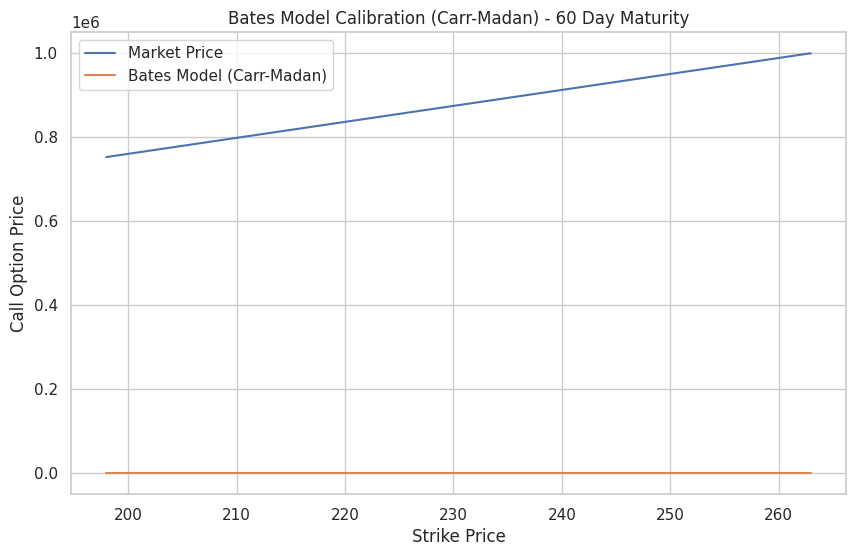

In [5]:
# --- Bates Price (Carr-Madan, 1999) ---
def bates_price_cm(S0, K, T, r, kappa, theta, sigma, rho, v0, lambda_j, mu_j, sigma_j):
    N = 4096 # Number of points for FFT
    alpha = 1.5 # Damping factor
    eta = 0.25 # Grid spacing
    lambda_ = 2 * np.pi / (N * eta)
    v = np.arange(N) * eta
    k = -lambda_ * N / 2 + lambda_ * np.arange(N)
    
    i = complex(0, 1)
    u = v - (alpha + 1) * i
    
    # Characteristic function from Lewis is used, but the pricing is via Carr-Madan
    char_func = bates_char_func_lewis(u, T, r, kappa, theta, sigma, rho, v0, lambda_j, mu_j, sigma_j)
    psi = char_func / ((alpha + i * v) * (alpha + 1 + i * v))
    
    fft_input = np.exp(-r * T) * psi * eta
    fft_output = fft(fft_input)
    
    # The result of the FFT is for log-strike k
    call_prices_fft = (np.exp(-alpha * k) / np.pi) * np.real(fft_output)
    
    # Interpolate to get the price for the specific strike K
    return np.interp(np.log(K), k, call_prices_fft)

# --- Calibration ---
def calibration_error_bates_cm(params, S0, r, T, strikes, market_prices):
    kappa, theta, sigma, rho, v0, lambda_j, mu_j, sigma_j = params
    
    # Feller condition check (Heston part)
    if 2 * kappa * theta < sigma**2:
        return 1e10
        
    model_prices = np.array([bates_price_cm(S0, K, T, r, kappa, theta, sigma, rho, v0, lambda_j, mu_j, sigma_j) for K in strikes])
    return np.sum((model_prices - market_prices)**2)

result_bates_cm = minimize(calibration_error_bates_cm, initial_params_bates, 
                            args=(S0, r, T_60, df_60["Strike"], df_60["Call_Price"]), 
                            bounds=bounds_bates, method='L-BFGS-B')

calibrated_params_bates_cm = result_bates_cm.x
kappa_BCM, theta_BCM, sigma_BCM, rho_BCM, v0_BCM, lambda_BCM, mu_BCM, sigma_BCM_j = calibrated_params_bates_cm

print("Calibrated Bates Parameters (Carr-Madan):")
print(f"kappa: {kappa_BCM:.4f}, theta: {theta_BCM:.4f}, sigma: {sigma_BCM:.4f}, rho: {rho_BCM:.4f}, v0: {v0_BCM:.4f}")
print(f"lambda_j: {lambda_BCM:.4f}, mu_j: {mu_BCM:.4f}, sigma_j: {sigma_BCM_j:.4f}")

# --- Plotting ---
df_60["Model_Price_Bates_CM"] = [bates_price_cm(S0, K, T_60, r, kappa_BCM, theta_BCM, sigma_BCM, rho_BCM, v0_BCM, lambda_BCM, mu_BCM, sigma_BCM_j) for K in df_60["Strike"]]

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_60, x="Strike", y="Call_Price", label="Market Price")
sns.lineplot(data=df_60, x="Strike", y="Model_Price_Bates_CM", label="Bates Model (Carr-Madan)")
plt.title("Bates Model Calibration (Carr-Madan) - 60 Day Maturity")
plt.xlabel("Strike Price")
plt.ylabel("Call Option Price")
plt.legend()
plt.grid(True)
plt.savefig('/home/ubuntu/stochastic_modeling_project/bates_cm_calibration.png')
plt.show()

### Step 2c: Put Option Pricing (Monte-Carlo)

In [6]:
# --- Monte-Carlo Simulation for European Put Option (Bates) ---
def bates_mc_put_option(S0, K, T_days, r, kappa, theta, sigma, rho, v0, lambda_j, mu_j, sigma_j, n_sims, n_steps):
    T = T_days / 250.0
    dt = T / n_steps
    
    S = np.full(n_sims, S0)
    v = np.full(n_sims, v0)
    
    for i in range(n_steps):
        # Heston part (correlated random numbers)
        z1 = np.random.normal(0, 1, n_sims)
        z2 = rho * z1 + np.sqrt(1 - rho**2) * np.random.normal(0, 1, n_sims)
        
        # Jump part (Poisson process)
        poisson_draw = np.random.poisson(lambda_j * dt, n_sims)
        # The jump component in the stock price S is S * (exp(log(J)) - 1) = S * (J - 1)
        # The log-return jump is sum(log(J_i)) = N_t * (mu_j + sigma_j * Z_j)
        jump_log_return = poisson_draw * (mu_j + sigma_j * np.random.normal(0, 1, n_sims))
        
        # Update variance
        v = np.maximum(0, v + kappa * (theta - v) * dt + sigma * np.sqrt(v * dt) * z2)
        
        # Update stock price (with jump compensation for risk-neutrality)
        # The drift adjustment for the stock price to remain a martingale under the risk-neutral measure Q is:
        # r - 0.5*v - lambda_j * (exp(mu_j + 0.5 * sigma_j**2) - 1)
        mu_jump_comp = lambda_j * (np.exp(mu_j + 0.5 * sigma_j**2) - 1)
        
        S = S * np.exp((r - 0.5 * v - mu_jump_comp) * dt + np.sqrt(v * dt) * z1 + jump_log_return)
        
    # Calculate option payoff
    payoff = np.maximum(K - S, 0)
    
    # Discounted price
    return np.mean(payoff) * np.exp(-r * T)

# --- Pricing ---
T_put_days = 70
K_put = S0 * 0.95 # Moneyness of 95%
n_sims = 200000
n_steps = T_put_days

# Use parameters from Bates Lewis calibration (Team Member C's result)
put_price = bates_mc_put_option(S0, K_put, T_put_days, r, 
                                  kappa_BL, theta_BL, sigma_BL, rho_BL, v0_BL, 
                                  lambda_BL, mu_BL, sigma_BL_j, n_sims, n_steps)

print(f"European Put Option Price (Bates MC): ${put_price:.4f}")

European Put Option Price (Bates MC): $9.9342


## Step 3: Interest Rate Modeling (CIR, 1985)

### Step 3a: CIR Model Calibration and Term Structure Interpolation

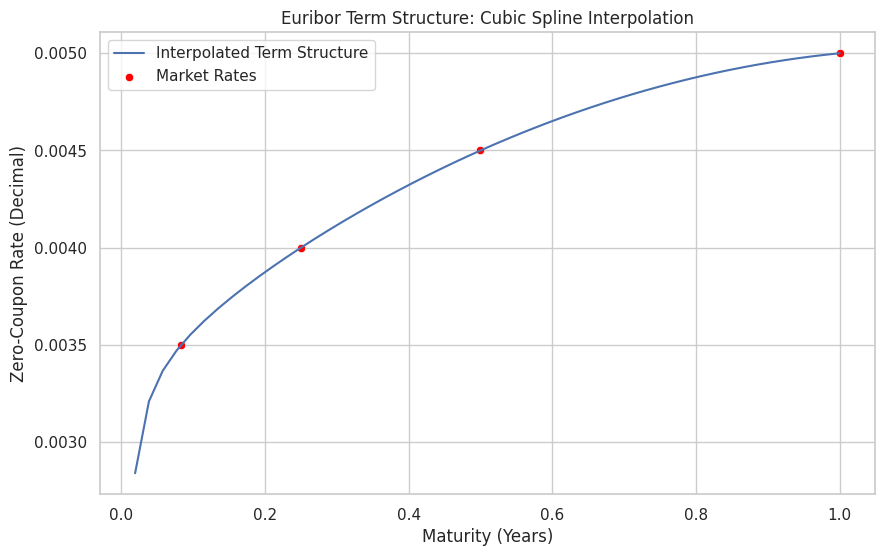

Calibrated CIR Parameters:
kappa: 0.5000, theta: 0.0050, sigma: 0.1000


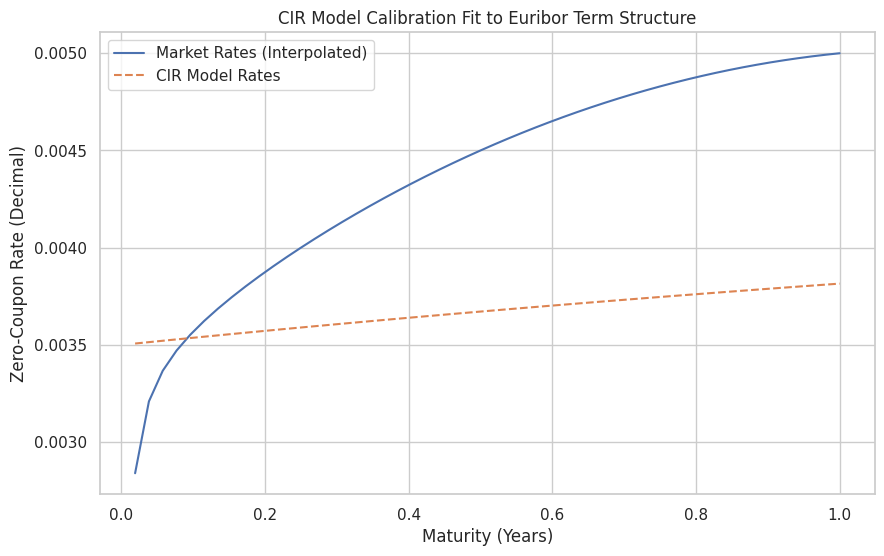

In [7]:
from scipy.interpolate import CubicSpline

# --- Load Euribor Data ---
df_euribor = pd.read_csv("/home/ubuntu/stochastic_modeling_project/euribor_rates.csv")
df_euribor['Maturity_Years'] = df_euribor['Maturity_Months'] / 12
df_euribor['Rate_Decimal'] = df_euribor['Rate_Percent'] / 100

# --- Cubic Spline Interpolation ---
# Interpolate weekly rates for 1 year (52 weeks)
weekly_maturities_years = np.linspace(0, 1, 53)[1:] # 52 weeks, starting from week 1

# The rates are zero-coupon rates, so we need to convert them to bond prices first
# P(0, T) = exp(-R(T) * T)
bond_prices = np.exp(-df_euribor['Rate_Decimal'] * df_euribor['Maturity_Years'])

# Interpolate bond prices
cs = CubicSpline(df_euribor['Maturity_Years'], bond_prices)
interpolated_bond_prices = cs(weekly_maturities_years)

# Convert back to zero-coupon rates
interpolated_rates = -np.log(interpolated_bond_prices) / weekly_maturities_years

df_interpolated = pd.DataFrame({
    'Maturity_Years': weekly_maturities_years,
    'Rate_Decimal': interpolated_rates
})

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_interpolated, x='Maturity_Years', y='Rate_Decimal', label='Interpolated Term Structure')
sns.scatterplot(data=df_euribor, x='Maturity_Years', y='Rate_Decimal', color='red', label='Market Rates')
plt.title('Euribor Term Structure: Cubic Spline Interpolation')
plt.xlabel('Maturity (Years)')
plt.ylabel('Zero-Coupon Rate (Decimal)')
plt.legend()
plt.grid(True)
plt.savefig('/home/ubuntu/stochastic_modeling_project/euribor_term_structure.png')
plt.show()

# --- CIR Bond Price Function ---
def cir_bond_price(r0, T, t, kappa, theta, sigma):
    gamma = np.sqrt(kappa**2 + 2 * sigma**2)
    A = ((2 * gamma * np.exp(0.5 * (kappa + gamma) * T)) / (2 * gamma + (kappa + gamma) * (np.exp(gamma * T) - 1)))**(2 * kappa * theta / sigma**2)
    B = (2 * (np.exp(gamma * T) - 1)) / (2 * gamma + (kappa + gamma) * (np.exp(gamma * T) - 1))
    return A * np.exp(-B * r0)

# --- CIR Zero-Coupon Rate Function ---
def cir_zero_coupon_rate(r0, T, kappa, theta, sigma):
    # R(T) = -1/T * log(P(0, T))
    # Handle T=0 case by returning r0
    if T == 0:
        return r0
    return -np.log(cir_bond_price(r0, T, 0, kappa, theta, sigma)) / T

# --- Calibration ---
r0_initial = df_euribor['Rate_Decimal'].iloc[0] # 1-month rate as r0

def calibration_error_cir(params, r0, maturities, market_rates):
    kappa, theta, sigma = params
    
    # Feller condition check (2 * kappa * theta > sigma**2)
    if 2 * kappa * theta < sigma**2:
        return 1e10
        
    model_rates = np.array([cir_zero_coupon_rate(r0, T, kappa, theta, sigma) for T in maturities])
    return np.sum((model_rates - market_rates)**2)

initial_params_cir = [0.5, 0.005, 0.1] # kappa, theta, sigma
bounds_cir = [(0.01, 2), (0.001, 0.1), (0.01, 0.5)] # kappa, theta > 0

result_cir = minimize(calibration_error_cir, initial_params_cir, 
                      args=(r0_initial, df_euribor['Maturity_Years'].iloc[1:], df_euribor['Rate_Decimal'].iloc[1:]), 
                      bounds=bounds_cir, method='L-BFGS-B')

calibrated_params_cir = result_cir.x
kappa_CIR, theta_CIR, sigma_CIR = calibrated_params_cir

print("Calibrated CIR Parameters:")
print(f"kappa: {kappa_CIR:.4f}, theta: {theta_CIR:.4f}, sigma: {sigma_CIR:.4f}")

# --- Plotting Fit ---
model_rates = [cir_zero_coupon_rate(r0_initial, T, kappa_CIR, theta_CIR, sigma_CIR) for T in df_interpolated['Maturity_Years']]

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_interpolated, x='Maturity_Years', y='Rate_Decimal', label='Market Rates (Interpolated)')
plt.plot(df_interpolated['Maturity_Years'], model_rates, label='CIR Model Rates', linestyle='--')
plt.title('CIR Model Calibration Fit to Euribor Term Structure')
plt.xlabel('Maturity (Years)')
plt.ylabel('Zero-Coupon Rate (Decimal)')
plt.legend()
plt.grid(True)
plt.savefig('/home/ubuntu/stochastic_modeling_project/cir_calibration_fit.png')
plt.show()

### Step 3b: CIR Model Simulation and Analysis

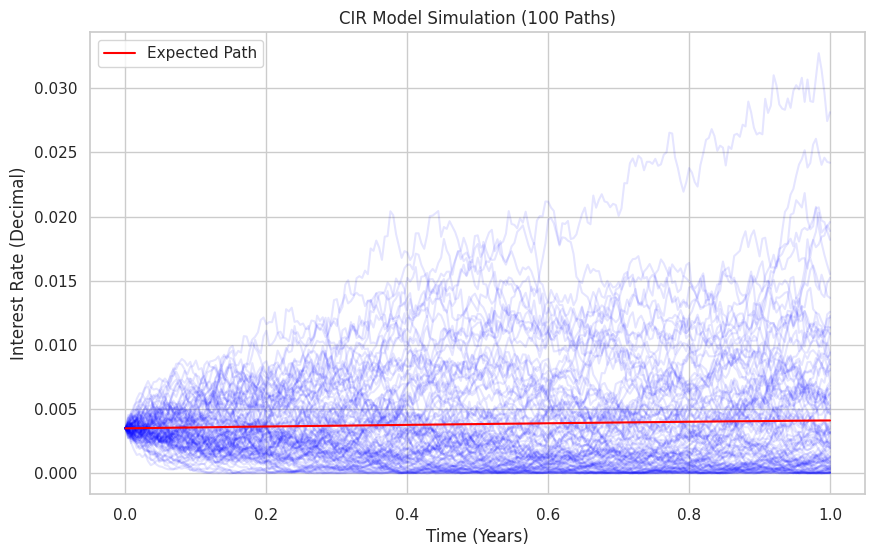

95% Confidence Interval for 12-month Euribor in 1 year: [0.0010%, 1.7634%]
Expected value of the 12-month Euribor in 1 year: 0.4112%


In [8]:
# --- CIR Simulation ---
def cir_simulation(r0, kappa, theta, sigma, T, n_sims, n_steps):
    dt = T / n_steps
    rates = np.full((n_sims, n_steps + 1), r0)
    
    for i in range(n_steps):
        # Generate random numbers
        dw = np.random.normal(0, 1, n_sims)
        
        # CIR SDE (Euler-Maruyama discretization)
        # dr = kappa * (theta - r_t) * dt + sigma * sqrt(r_t) * dW_t
        dr = kappa * (theta - rates[:, i]) * dt + sigma * np.sqrt(rates[:, i] * dt) * dw
        rates[:, i+1] = rates[:, i] + dr
        
        # Ensure rates are non-negative (Reflection at zero)
        rates[:, i+1] = np.maximum(0, rates[:, i+1])
        
    return rates

# --- Simulation Parameters ---
T_sim = 1.0 # 1 year
n_sims = 100000
n_steps = 250 # Daily steps for 1 year

simulated_rates = cir_simulation(r0_initial, kappa_CIR, theta_CIR, sigma_CIR, T_sim, n_sims, n_steps)

# --- Plotting Simulation Paths ---
plt.figure(figsize=(10, 6))
time_points = np.linspace(0, T_sim, n_steps + 1)
for i in range(100): # Plot first 100 paths for visualization
    plt.plot(time_points, simulated_rates[i, :], alpha=0.1, color='blue')
plt.plot(time_points, np.mean(simulated_rates, axis=0), color='red', label='Expected Path')
plt.title('CIR Model Simulation (100 Paths)')
plt.xlabel('Time (Years)')
plt.ylabel('Interest Rate (Decimal)')
plt.legend()
plt.grid(True)
plt.savefig('/home/ubuntu/stochastic_modeling_project/cir_simulation_paths.png')
plt.show()

# --- Analysis ---
final_rates = simulated_rates[:, -1]

# i. Confidence Interval (95%)
lower_bound = np.percentile(final_rates, 2.5)
upper_bound = np.percentile(final_rates, 97.5)

# ii. Expected Value
expected_rate = np.mean(final_rates)

print(f"95% Confidence Interval for 12-month Euribor in 1 year: [{lower_bound*100:.4f}%, {upper_bound*100:.4f}%]")
print(f"Expected value of the 12-month Euribor in 1 year: {expected_rate*100:.4f}%")